## <span style="color:blue">Attaching geo data to survey locations</span>

### <span style="color:#008891">The geo data is calculated weekly*</span>

__What this does:__ This notebook produces the population and infrastructure attribute rankings for each survey location.

__When to use it:__ After running 'getdataforrepo' run this notebook, the .csv file is used to map rankings and values to survey results.


#### Tasks:

1. Define the ranking boundaries for different geographic and demographic attributes at each survey location
2. Exports a file to resources/location_data directory:
   1. A .csv file with survey location data, attribute rankings and attribute values

The method used to create the rankings can be changed, right now everything is split along 20% increments of the measured value.   
   
\*This function will be automated in the future. For now this the responsibility of the lead analyst.

questions or comments: analyst@hammerdirt.ch

In [1]:
# sys, file and nav packages:
import os
import datetime as dt
import csv

# math packages:
import pandas as pd
import numpy as np
from scipy import stats
import datetime as dt 


# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
import seaborn as sns
import matplotlib.gridspec as gridspec
from IPython.display import display, HTML


# home brew utitilties
import utilities.utility_functions as ut

# documenting
from IPython.display import Markdown as md

display(HTML("""
<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;
}
</style>
"""))

In [2]:
# the local file structure. The resources are located in the corresponding directory.
# the purpose and date should be included in the filename when saving results to output
survey_data, location_data, code_defs, stat_ent, geo_data, output = ut.make_local_paths()

In [3]:
# variables/arrays that are frequently used:
# project lakes
the_lakes = [
    "Bielersee",
    "Walensee",
    "Lac Léman",
    "Zurichsee",
    "Neuenburgersee",
    "Thunersee",
    "Lago Maggiore",
    "Brienzersee",
    
]

the_rivs = [
    'Aare',
    'Rhône',
    'Limmat',
    'Linth',
    'Ticino',
]
# project beaches
poi = [
    "neuenburgersee_cudrefin_mattera",
    "la-petite-plage",
    "evole-plage",
    "plage-de-cheyres",
    "mullermatte",
    "bielersee_vinelz_fankhausers",
    "baby-plage-geneva",
    "baye-de-montreux-g",
    "grand-clos",
    "preverenges",
    "quai-maria-belgia",
    "zurichsee_wollishofen_langendorfm",
    "zurichsee_kusnachterhorn_thirkell-whitej",
    "zuerichsee_richterswil_benkoem_2",     
    "rastplatz-stampf",
    "weissenau-neuhaus",
    "thunersee_spiez_meierd_1",
    "walensee_walenstadt_wysse",
    "gasi-strand",
    "vira-gambarogno",
    "sentiero-giro-del-golf-spiaggia",
    "maladaire"
   
]

In [4]:
# standard formats already in use for charts 
# you can just apply these as kwargs to different elements...
table_k = dict(loc="top left", bbox=(0,0,1,1), colWidths=[.5, .5], cellLoc='center')
tablecenter_k = dict(loc="top left", bbox=(0,0,1,1), cellLoc='center')
tabtickp_k = dict(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False)
title_k = {'loc':'left', 'pad':10, 'linespacing':1.5, 'fontsize':12}
title_k20 = {'loc':'left', 'pad':10, 'linespacing':1.5, 'fontsize':12, 'color':'dodgerblue'}
title_k17 = {'loc':'left', 'pad':10, 'linespacing':1.5, 'fontsize':12, 'color':'salmon'}
titler_k20 = {'loc':'right', 'pad':10, 'linespacing':1.5, 'fontsize':12, 'color':'dodgerblue'}
titler_k17 = {'loc':'right', 'pad':10, 'linespacing':1.5, 'fontsize':12, 'color':'salmon'}
xlab_k = {'labelpad':10, 'fontsize':12}
ylab_k = {'labelpad':14, 'fontsize':14}
titler_k = {'loc':'right', 'pad':10, 'linespacing':1.5, 'fontsize':12}

# use these to format date axis in charts
weeks = mdates.WeekdayLocator(byweekday=1, interval=4)
days = mdates.DayLocator(bymonthday=1, interval=1)
months = mdates.MonthLocator(bymonth=[3,6,9,12])
wks_fmt = mdates.DateFormatter('%d')
mths_fmt = mdates.DateFormatter('%b')

In [5]:
# aggregated survey data
dfAgg = pd.read_csv(F"{survey_data}/results_with_zeroes_aggregated_parent.csv")
dfAgg['date'] = pd.to_datetime(dfAgg['date'])

# non aggregated survey data
dfSurveys = pd.read_csv(F"{survey_data}/results_with_zeroes.csv")
dfSurveys['date'] = pd.to_datetime(dfSurveys['date'])

# beach data
dfBeaches = pd.read_csv(F"{location_data}/beaches_pop_bfs.csv")

# population data
popdata = pd.read_csv(F"{stat_ent}/STATPOP2018_GMDE.csv")
popdata.set_index('GDENR', inplace=True, drop=True)

# bfs number and commune keys
popkeys = pd.read_csv(F"{stat_ent}/bfs_num.csv")
# popkeys.set_index('GDENR', inplace=True, drop=True)

# the list of riparian communities
riparian = pd.read_csv(F"{stat_ent}/riparian_communities.csv")

# gis data, set the index to slug and get rid of the old index:
blds = pd.read_csv(F"{geo_data}/exp_variables/blds_500m.csv")
blds.set_index('slug', inplace=True, drop=True)
streets = pd.read_csv(F"{geo_data}/exp_variables/strasse_1000m_length.csv")
streets.set_index('slug', inplace=True, drop=True)
intersects = pd.read_csv(F"{geo_data}/exp_variables/river_intersect_lakes.csv")
intersects.set_index('slug', inplace=True, drop=True)

# code definitions
dfCodes = pd.read_csv(F"{code_defs}/mlw_codes.csv")

In [6]:
dfSurveys.loc[(dfSurveys.date =='2020-07-07')&(dfSurveys.location == 'grand-clos')].quantity.sum()

1475

In [7]:
project_directory = ut.make_project_folder(location_data, 'infrastructure_rankings')

That project exists


### <span style="color:#008891">Map GIS data to beach data</span>

When the attributes surounding each survey location are calculated in QGIS the data is keyed to the survey location 'slug'. Therefore the 'slug' column of the beach data can be used to map the results from the GIS data to the beach data.

In [8]:
def check_values(df, x, column):
    if x in df.index:
        package = df.loc[x][column]
    else:
        package = 0
    return package
    
dfBeaches['buildings'] = dfBeaches.slug.map(lambda x:check_values(blds, x, "area"))
no_buildings = dfBeaches[dfBeaches.buildings == 0]

dfBeaches['streets'] = dfBeaches.slug.map(lambda x:check_values(streets, x, "LENGTH"))
no_streets = dfBeaches[dfBeaches.streets == 0]

dfBeaches['intersects'] = dfBeaches.slug.map(lambda x:check_values(intersects, x, "NUMPOINTS"))
no_intersects = dfBeaches[dfBeaches.intersects == 0]

#### <span style="color:#008891">Rank the locations by attribute value</span>

In [9]:
rip_bns = riparian.BFS_NUMMER.unique()
pop_bns = popdata.index

missing = [x for x in rip_bns if x not in pop_bns]

print(missing)

[9150, 9711, 9152, 293]


We are missing the population data from 4 of the 402 riparian communities inlcuded in this analysis. Make sure that none of those municipalities have a survey.

In [10]:
# look for beaches that in the missing data array
print([x for x in dfBeaches.bfsnum.values if x in missing])

[]


In [11]:
# get the 400 remaining populations from the riparian communities
rip_pop = popdata.loc[popdata.index.isin([x for x in rip_bns if x not in missing])]
print(F"This is the summary data of the riparian municipalities of the study:\n{rip_pop['B18BTOT'].describe()}\n")

# break up the population by percentiles
boundaries_rip = np.percentile(rip_pop['B18BTOT'], [12.5, 25, 37.5,50,62.5,75,87.5])
boundaries_proj = np.percentile(dfBeaches[dfBeaches.water_name.isin(the_lakes)]['population'], [20,40,60,80])

# make boundary pairs of the percentile
def make_boundaries(percentiles):
    i = len(percentiles)
    end = i-1
    package = []
    for j,limit in enumerate(percentiles):
        if j == 0:
            this_limit = (0, limit)
        elif j == end:
            this_limit = (limit, 0)
        else:
            this_limit = (percentiles[j-1], limit)
        package.append(this_limit)
    return package
bound_tuples_rip = make_boundaries(boundaries_rip)
bound_tuples_proj = make_boundaries(boundaries_proj)

print(F"\nThis is the boundaries by 20th percentile of the project beaches:\n{bound_tuples_proj}")

This is the summary data of the riparian municipalities of the study:
count       398.000000
mean       7469.213568
std       25601.489087
min          33.000000
25%        1065.750000
50%        2891.500000
75%        6170.500000
max      415367.000000
Name: B18BTOT, dtype: float64


This is the boundaries by 20th percentile of the project beaches:
[(0, 2937.0), (2937.0, 5481.0), (5481.0, 12812.0), (26999.0, 0)]


In [12]:
# apply those boundaries to the beach data:
# print(boundaries)
def apply_boundaries(the_tuples, x):
    groups = np.arange(1, len(the_tuples))
    end = len(the_tuples)-1
    group = 0
    for i,a_tuple in enumerate(the_tuples):
        if i == end:
            group = i
            break
        elif x >= a_tuple[0] and x < a_tuple[1]:
            group = i
            break
    return group

dfBeaches['pop_group_proj'] = dfBeaches.population.map(lambda x: apply_boundaries(bound_tuples_proj, x))
dfBeaches['pop_group_rip'] = dfBeaches.population.map(lambda x: apply_boundaries(bound_tuples_rip, x))

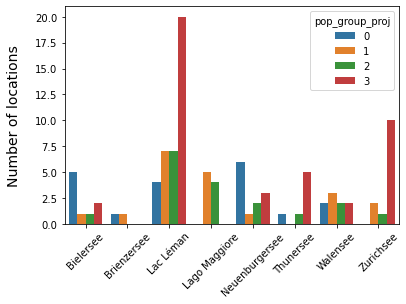

In [13]:
data = dfBeaches[dfBeaches.water_name.isin(the_lakes)].groupby(['water_name','pop_group_proj'], as_index=False).slug.count()
fig, ax = plt.subplots()

g = sns.barplot(data=data, x='water_name', y='slug', hue='pop_group_proj', ax=ax)
ax.tick_params(axis='x', rotation=45)
ax.set_ylabel("Number of locations", **ylab_k)
ax.set_xlabel("",)

plt.show()

#### <span style="color:#008891">Rank the geo data</span>

The total length of streets and the surface area allocated to buildings can be grouped like population. The river intersects are already in a count format ie.. number of river intersections within 1500m of the survey location.

In [14]:
# use the same percentiles as population:

percents = [20,40,60,80]

streetsp = np.percentile(dfBeaches[dfBeaches.water_name.isin(the_lakes)]['streets'], percents)
bldsp = np.percentile(dfBeaches[dfBeaches.water_name.isin(the_lakes)]['buildings'], percents)

bound_tuples_streets = make_boundaries(streetsp)
bound_tuples_builds = make_boundaries(bldsp)

dfBeaches['streets_rank'] = dfBeaches.population.map(lambda x: apply_boundaries(bound_tuples_streets, x))
dfBeaches['buildings_rank'] = dfBeaches.population.map(lambda x: apply_boundaries(bound_tuples_builds, x))
print(bound_tuples_builds )

[(0, 7931.223800000001), (7931.223800000001, 22441.332200000004), (22441.332200000004, 33825.56), (70168.41280000003, 0)]


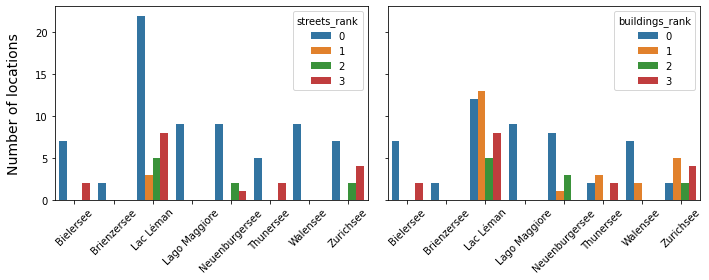

In [15]:
data_streets = dfBeaches[dfBeaches.water_name.isin(the_lakes)].groupby(['water_name','streets_rank'], as_index=False).slug.count()
data_builds = dfBeaches[dfBeaches.water_name.isin(the_lakes)].groupby(['water_name','buildings_rank'], as_index=False).slug.count()
fig, axs = plt.subplots(1,2, figsize=(10,4), sharey=True)

ax1 = sns.barplot(data=data_streets, x='water_name', y='slug', hue='streets_rank', ax=axs[0])
ax2 = sns.barplot(data=data_builds, x='water_name', y='slug', hue='buildings_rank', ax=axs[1])
ax1.set_ylabel("Number of locations", **ylab_k)
ax2.set_ylabel("")
ax1.set_xlabel("")
ax2.set_xlabel("")
ax1.tick_params(axis='x', rotation=45)
ax2.tick_params(axis='x', rotation=45, labelright=True)
plt.tight_layout()
plt.show()

#### <span style="color:#008891">Export the data</span>

In [16]:
filename = F"{location_data}/beaches_with_ranks.csv"
dfBeaches.to_csv(filename, index=False)

#### Hopefully that just worked for you

if not contact analyst@hammerdirt.ch